# Exercise 3 | TKO_7092 Evaluation of Machine Learning Methods 2023
## deadline: 15.2.2023 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Guanghang Chen

Student number: 521084

Student email: guchen@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with **K=5 (5NN)**, using spatial leave-one-out cross-validation (i.e. SKCV, with **number of folds == number of data points**). The client wants you to use the **C-index** as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 5-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 5NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 for help). Estimate the water permeability prediction performance (using 5NN model and C-index) with the following distance parameter values: d = 0, 10, 20, ..., 250 (that is, 10 meter intervals from 0m to 250m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. Remember to also take advantage of earlier exercises (e.g. C-index). For the 5-nearest neighbor and Euclidean distance calculation you can use third-party libraries (e.g. Scikit-learn) if you want. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
#
# Note that the coordinates are in EUREF-TM35FIN format, so you 
# can use the Euclidean distance to calculate the distance between two coordinate points.  

input_df = pd.read_csv('./input.csv', header=None)
output_df = pd.read_csv('./output.csv', header=None)
coord_df = pd.read_csv('./coordinates.csv', header=None)

print(f"input_df : {input_df.shape}")
print(f"output_df : {output_df.shape}")
print(f"coord_df : {coord_df.shape}")



input_df : (1691, 75)
output_df : (1691, 1)
coord_df : (1691, 2)


### Standardization of the predictor features (input.csv)

In [3]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

input_scaled_df = (input_df - input_df.mean()) / input_df.std()


print(f"input_scaled_df\n mean: {input_scaled_df.mean().sum()} \n var : {input_scaled_df.std().sum()}")

input_scaled_df
 mean: -4.832194832194651e-16 
 var : 74.99999999999994


### Functions

In [4]:
# Include here all the functions (for example the C-index-function) that you need in order to implement the task.
"""
C-index function: 
- INPUTS: 
'y' an array of the true output values
'yp' an array of predicted output values
- OUTPUT: 
The c-index value
"""
def cindex(true_labels, pred_labels):
    """Returns C-index between true labels and predicted labels"""  
    n = 0
    h_num = 0
    for i in range(0, len(true_labels)):
        t = true_labels[i]
        p = pred_labels[i]
        for j in range(i+1, len(true_labels)):
            nt = true_labels[j]
            np = pred_labels[j]
            if (t != nt):
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt):
                    h_num += 1
                elif (p==np):
                    h_num += 0.5
                    
    
    return h_num / n



"""
Implementation leave spaital out cross validation
- INPUTS
'input_df' input features dataframe
'output_df'  output dataframe
'coord_df' coordinate distance dataframe
'filtered_radius_groups'  a list of filtering distances
'model'  evualting model
- OUTPUT
'c_index_result' a list of c-index evulation from each loop

"""
def spatial_loocv(input_df, output_df, coord_df, filtered_radius_groups, model):
    c_index_result = list()
    for filtered_radius in filtered_radius_groups:
        print(f"Filtering out input instance within {filtered_radius} meter")
        y_true, y_pred = list(), list()
        ## leave one out loop
        for test_index in range(input_df.shape[0]):
            train_index = np.delete(input_df.index.tolist(), test_index).tolist()
            train_index_filtered = list()
            ## filtering out depedent data points 
            for i in range(len(train_index)):
                dist = euclidean_distances([coord_df.values[test_index]], [coord_df.values[train_index[i]]])[0][0]
                if dist > filtered_radius:
                    train_index_filtered.append(train_index[i])
            ## prepare train and test data
            X_train, y_train = input_df.values[train_index_filtered], output_df.values[train_index_filtered]
            X_test, y_test = input_df.values[[test_index]], output_df.values[[test_index]]
            ## train and predict
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            y_true.append(y_test)
            y_pred.append(pred[0])
        ## calculate c_index in different filtering radius
        c_index = cindex(y_true, y_pred)
        print("c_index is {}".format(c_index))
        c_index_result.append(c_index)
    
    return c_index_result     

In [5]:
#test cindex function with following values
true_labels = [-1, 1, 1, -1, 1]
predictions = [0.60, 0.80, 0.75, 0.75, 0.70]
cindx = cindex(true_labels, predictions)
print(cindx)



0.75


### Results for spatial leave-one-out cross-validation with 5-nearest neighbor regression model

In [6]:
%%time
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 5-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

knn = KNeighborsRegressor(n_neighbors=5)

filter_radius_groups = np.arange(0, 251, 10)

 
c_index_result = spatial_loocv(input_scaled_df, output_df, coord_df, filter_radius_groups, knn)


Filtering out input instance within 0 meter
c_index is 0.7128399518989149
Filtering out input instance within 10 meter
c_index is 0.7036015617453583
Filtering out input instance within 20 meter
c_index is 0.7071685455861375
Filtering out input instance within 30 meter
c_index is 0.7055939910041451
Filtering out input instance within 40 meter
c_index is 0.6982335870446251
Filtering out input instance within 50 meter
c_index is 0.691912270116431
Filtering out input instance within 60 meter
c_index is 0.6910579718869037
Filtering out input instance within 70 meter
c_index is 0.6862394638884883
Filtering out input instance within 80 meter
c_index is 0.6835099792952547
Filtering out input instance within 90 meter
c_index is 0.6819959710441548
Filtering out input instance within 100 meter
c_index is 0.6805834566425275
Filtering out input instance within 110 meter
c_index is 0.6370926421858836
Filtering out input instance within 120 meter
c_index is 0.6170220584632571
Filtering out input inst

### Interpretation of the results

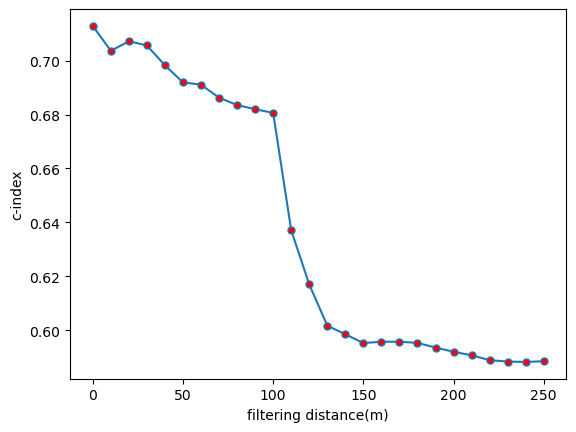

In [17]:
# In this cell, give a brief commentary on the results, what happens to the prediction 
# performance as the prediction distance increases?

plt.figure()

plt.plot(filter_radius_groups, c_index_result, marker='.', markerfacecolor='red', markersize = 10)
plt.xlabel('filtering distance(m)')
plt.ylabel('c-index')

plt.show()

The basic idea of cross validation and its variants is split available dataset into training and testing set then evaluating the model's performance on an independent subject. 

As we can see from the plotting above, the c-index is decrease as filtering distance increase. its slowly decrease from 0.71 at 0 meter, and fall to 0.61 at 120 meter. finally, reach plaeatue around 0.58 at 250 meter. We can clearly observe how spaital datapoint hold independetn as filtering distance increasing.